In [1]:
from PyEMD import EMD, EEMD
from PyEMD.visualisation import Visualisation 
import numpy  as np
import pylab as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
eemd=EEMD()
emd = eemd.EMD
emd.extrema_detection = 'parabol'

## 读取时间序列


In [3]:
GMST = pd.read_csv("avarangeof6.csv",header= 0,index_col= 0,names=["GMST"])['GMST'].to_numpy()
GMST
date = pd.read_csv("avarangeof6.csv",header= 0,index_col= 0,names=["GMST"])['GMST'].index

## 参数设置

In [4]:
t0 = 1880
dt =1
N = GMST.size
t = np.arange(0,N)*dt + t0

In [5]:
p=np.polyfit(t - t0,GMST,1)
GMST_notrend=GMST
std=GMST_notrend.std()
var=std**2
GMST_norm=GMST_notrend

In [6]:
eIMFs = eemd.eemd(GMST_norm,t)
nIMFs = eIMFs.shape[0]

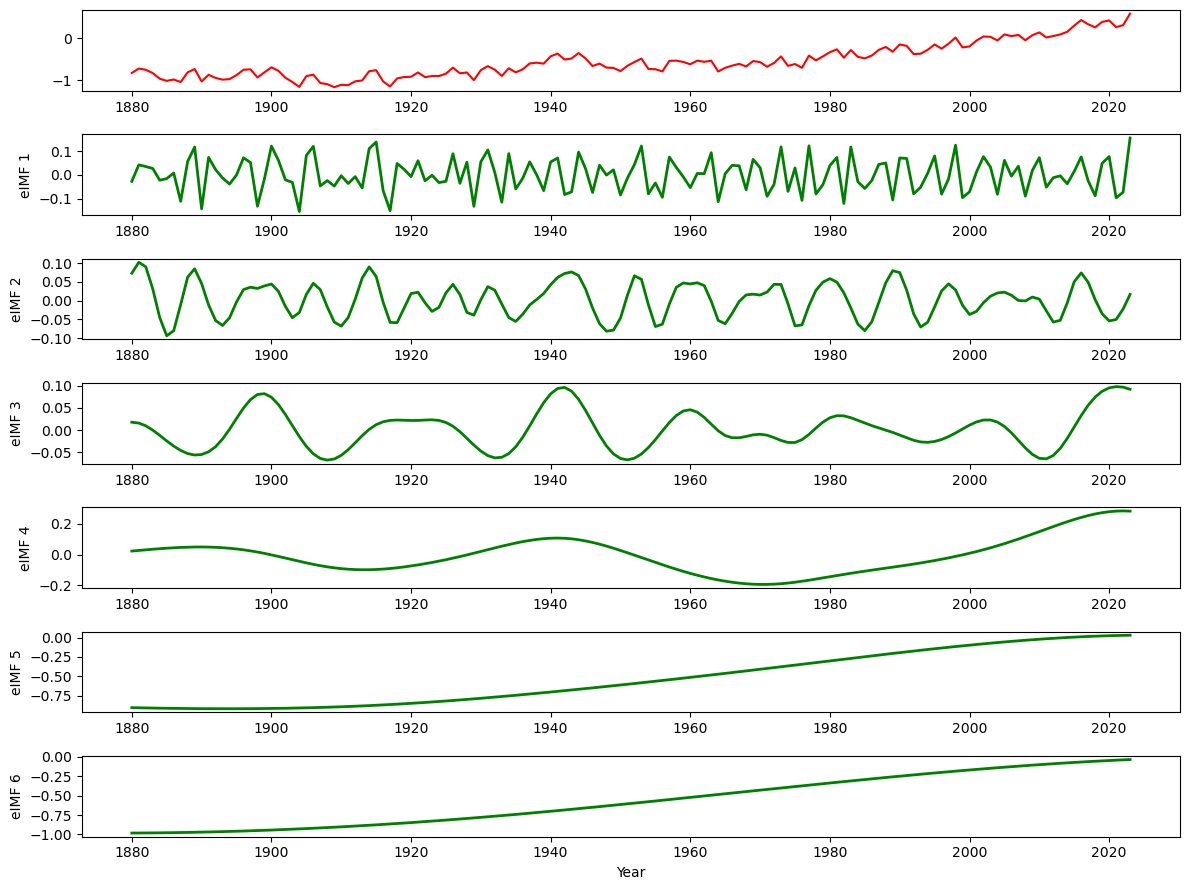

In [7]:
plt.figure(figsize=(12,9))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(t, GMST_norm, 'r')
for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    plt.plot(t, eIMFs[n], 'g',lw = 2.0)
    plt.ylabel("eIMF %i" %(n+1))
    plt.locator_params(axis='y', nbins=5)
plt.xlabel("Year")
plt.tight_layout()
plt.show()

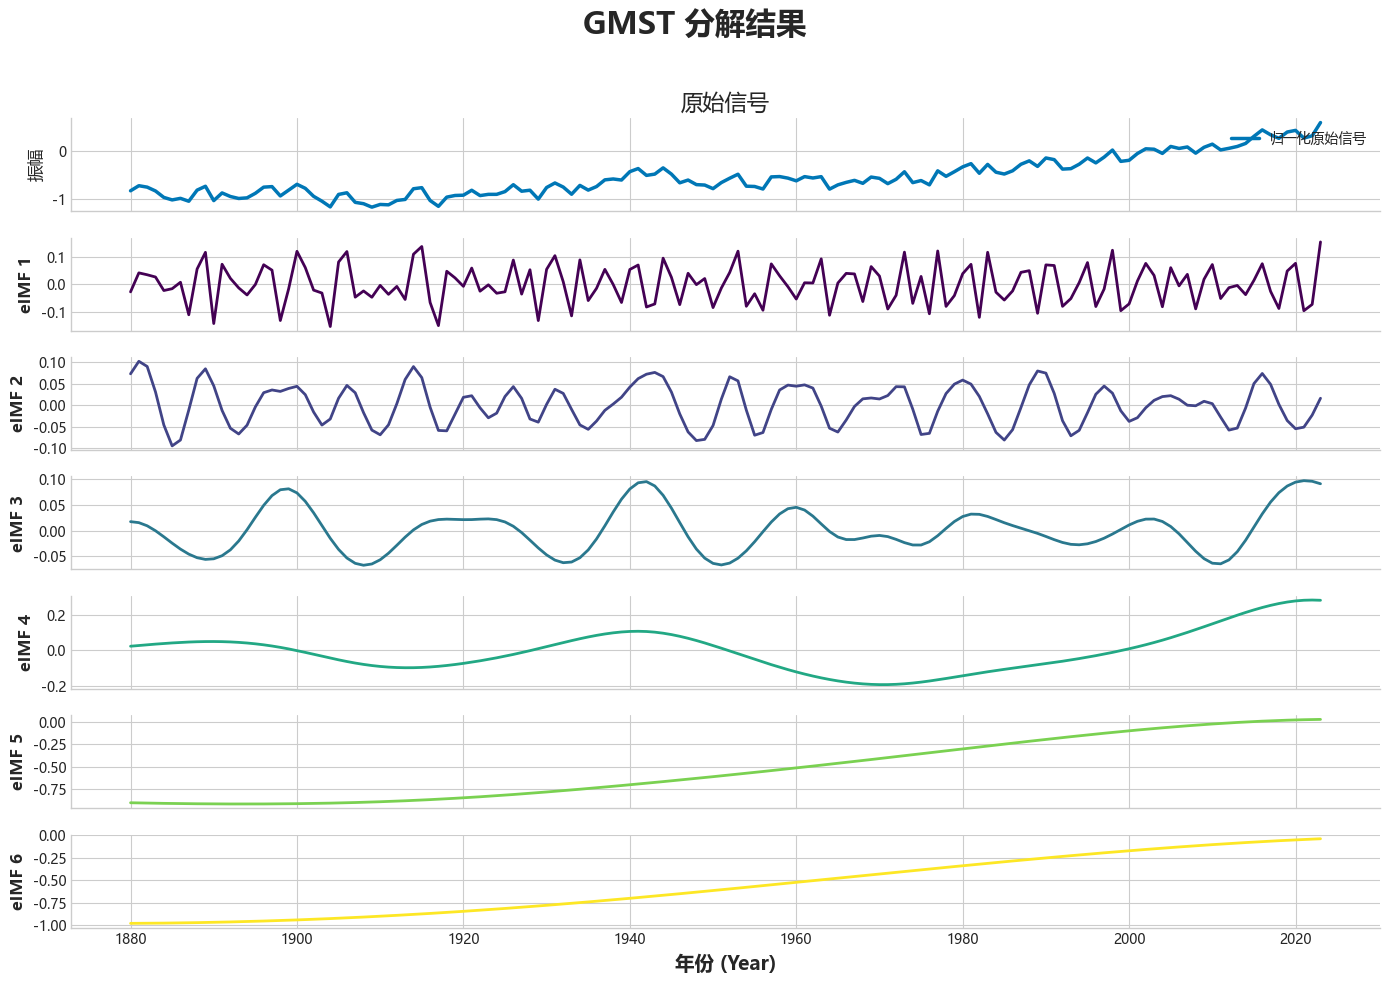

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# --- 设置专业绘图风格 ---
# 使用 seaborn 风格，白色网格背景，看起来更清爽
plt.style.use('seaborn-v0_8-whitegrid')
# 设置全局字体，确保中文或特殊符号能正常显示（如果需要）
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

# --- 创建图形和子图 ---
# 使用 plt.subplots() 可以更灵活地控制所有子图
# sharex=True 让所有子图共享X轴，更整洁
fig, axes = plt.subplots(nIMFs + 1, 1, figsize=(14, 10), sharex=True)

# --- 主标题 ---
fig.suptitle('GMST 分解结果', fontsize=22, fontweight='bold')

# --- 绘制第一个子图：原始信号 ---
axes[0].plot(t, GMST, color='#0077b6', lw=2.5, label='归一化原始信号')
axes[0].set_title('原始信号', fontsize=16)
axes[0].set_ylabel('振幅', fontsize=12)
axes[0].legend(loc='upper right')
# 移除顶部和右侧的边框线，更美观
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)


# --- 循环绘制所有 IMF 子图 ---
# 使用 'viridis' 颜色映射，让每个 IMF 颜色不同且有规律
colors = plt.cm.viridis(np.linspace(0, 1, nIMFs))

for n in range(nIMFs):
    ax = axes[n+1]
    ax.plot(t, eIMFs[n], color=colors[n], lw=2.0)
    ax.set_ylabel(f"eIMF {n+1}", fontsize=12, fontweight='bold')
    
    # 移除顶部和右侧的边框线
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # 调整Y轴刻度线密度
    ax.locator_params(axis='y', nbins=5)

# --- 设置共享的 X 轴标签 ---
# 只在最下方的图显示X轴标签
plt.xlabel("年份 (Year)", fontsize=14, fontweight='bold')

# --- 优化布局并显示图像 ---
plt.tight_layout(rect=[0, 0, 1, 0.96]) # 调整布局，为主标题留出空间
plt.show()

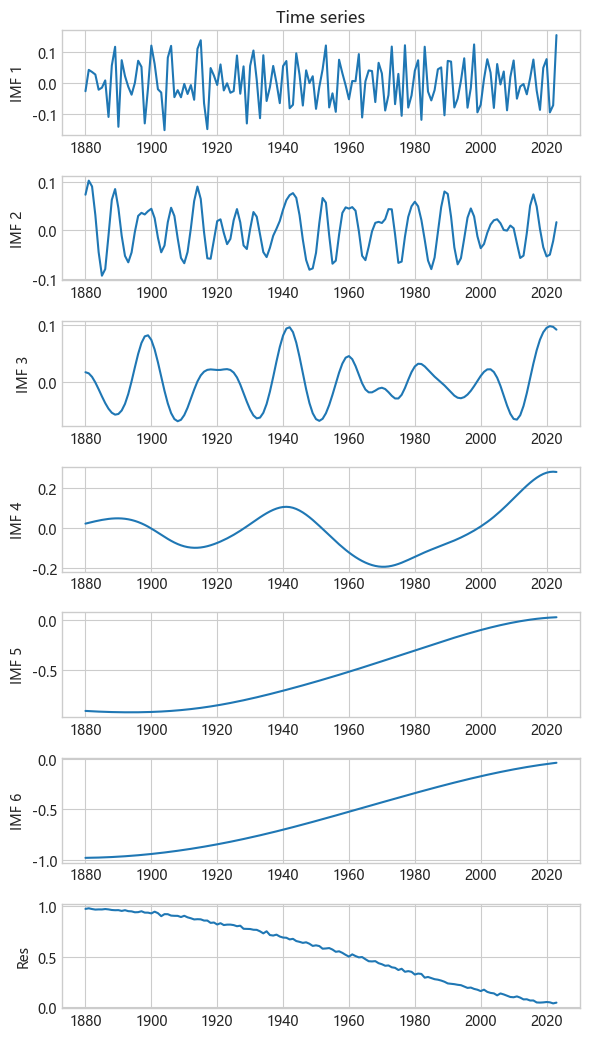

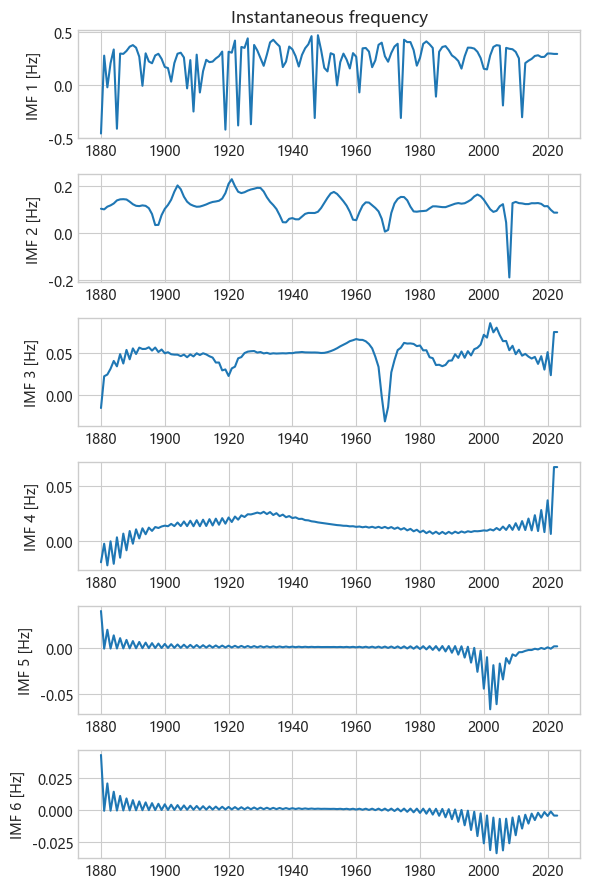

In [9]:
imfs,res = eemd.get_imfs_and_residue()
vis = Visualisation()
vis.plot_imfs(imfs=imfs,residue=res,t = t,include_residue=True)
vis.plot_instant_freq(t,imfs=imfs)
vis.show()

FFT 分析出的主周期为: 144.00 年


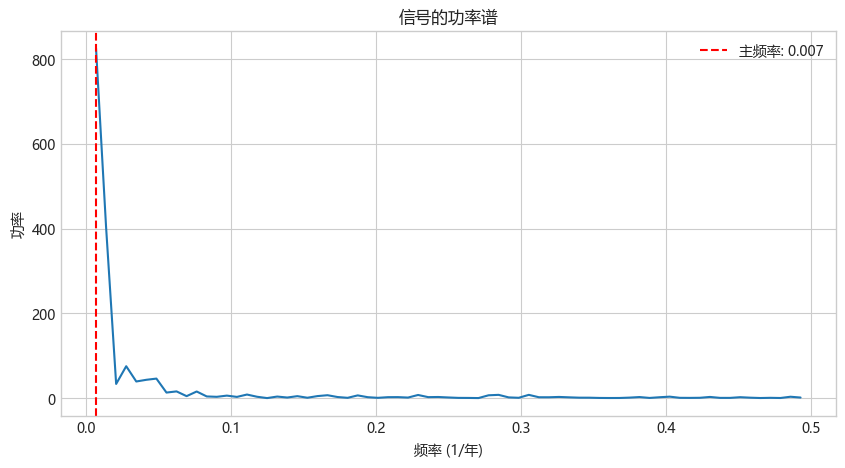

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 GMST_norm 是您的原始信号，t 是时间
# 假设时间是等间隔的
sampling_interval = t[1] - t[0] # 计算采样间隔
n_points = len(GMST_norm)

# 进行 FFT
fft_vals = np.fft.fft(GMST_norm)
# 计算频率轴
fft_freq = np.fft.fftfreq(n_points, d=sampling_interval)
# 计算功率谱
power_spectrum = np.abs(fft_vals)**2

# --- 寻找峰值 ---
# 我们只关心正频率部分
positive_freq_mask = fft_freq > 0
freqs = fft_freq[positive_freq_mask]
power = power_spectrum[positive_freq_mask]

# 找到功率最大的点的索引
dominant_freq_index = np.argmax(power)
# 找到主频率
dominant_freq = freqs[dominant_freq_index]
# 计算主周期
dominant_period = 1 / dominant_freq

print(f"FFT 分析出的主周期为: {dominant_period:.2f} 年")

# --- 绘图 ---
plt.figure(figsize=(10, 5))
plt.plot(freqs, power)
plt.title('信号的功率谱')
plt.xlabel('频率 (1/年)')
plt.ylabel('功率')
plt.axvline(dominant_freq, color='r', linestyle='--', label=f'主频率: {dominant_freq:.3f}')
plt.legend()
plt.show()

In [11]:
import numpy as np

def get_average_period(imf, t):
    """
    通过计算极值点之间的平均距离来估算 IMF 的周期。
    
    参数:
    imf (np.array): 单个 IMF 时间序列。
    t (np.array): 对应的时间数组。
    
    返回:
    float: 估算的平均周期长度。
    """
    # 寻找局部最大值的索引
    # 使用 scipy.signal.find_peaks 会更鲁棒，这里用一个简化版
    peaks_indices = (np.diff(np.sign(np.diff(imf))) < 0).nonzero()[0] + 1
    
    if len(peaks_indices) < 2:
        return np.nan # 极值点太少，无法计算周期
        
    # 计算极值点之间的时间间隔
    peak_times = t[peaks_indices]
    periods = np.diff(peak_times)
    
    # 返回平均周期
    return np.mean(periods)

# 假设 eIMFs 是您 EEMD 分解后的结果，t 是时间
# 并且您通过观察认为 eIMFs[3] 是一个重要的周期成分
for i in range(6):
    target_imf = eIMFs[i] 
    estimated_period = get_average_period(target_imf, t)
    
    print(f"eIMF {i+1} 的估算平均周期为: {estimated_period:.2f} 年")

# 这样，您就“提取”并“识别”出了一个周期
# 而 target_imf 本身就是被“分离”出来的周期信号

eIMF 1 的估算平均周期为: 3.09 年
eIMF 2 的估算平均周期为: 6.75 年
eIMF 3 的估算平均周期为: 15.25 年
eIMF 4 的估算平均周期为: 66.00 年
eIMF 5 的估算平均周期为: nan 年
eIMF 6 的估算平均周期为: nan 年


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# 假设 eIMFs 和 t 是您已经拥有的 EEMD 分解结果和时间序列
# eIMFs.shape[0] 是 IMF 的数量
nIMFs = eIMFs.shape[0]

# --- 核心计算流程 ---

# 采样率 (每年的点数，假设时间单位是年且等间隔)
sampling_rate = 1 / (t[1] - t[0]) 

print(f"数据采样率: {sampling_rate:.2f} Hz (点/年)\n")

# 存储每个IMF的平均周期
average_periods = []

for i, imf in enumerate(eIMFs):
    # 1. 对 IMF 进行希尔伯特变换
    analytic_signal = hilbert(imf)
    
    # 2. 计算瞬时相位
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    
    # 3. 计算瞬时频率 (d(phase)/dt)
    # 瞬时频率的单位是 rad/sample，乘以 sampling_rate / (2*pi) 转换为 Hz (cycles/year)
    instantaneous_freq = (np.diff(instantaneous_phase) / (2.0 * np.pi) * sampling_rate)
    
    # 忽略频率过低或不稳定的边缘点，取中间稳定部分计算
    stable_part_freq = instantaneous_freq[10:-10]
    
    # 4. 从瞬时频率计算平均周期 (T = 1/f)
    # 避免除以零的错误
    if np.mean(stable_part_freq) > 1e-6:
        avg_period = 1 / np.mean(stable_part_freq)
    else:
        avg_period = np.inf # 频率接近0，周期为无穷大（趋势项）
        
    average_periods.append(avg_period)
    
    print(f"eIMF {i+1}:")
    print(f"  - 平均频率: {1/avg_period:.4f} cycles/year")
    print(f"  - 平均周期: {avg_period:.2f} years")

# --- 结果展示 ---
print("\n--- 周期提取结果汇总 ---")
for i, period in enumerate(average_periods):
    print(f"eIMF {i+1} 的代表周期是: {period:.2f} 年")

数据采样率: 1.00 Hz (点/年)

eIMF 1:
  - 平均频率: 0.2348 cycles/year
  - 平均周期: 4.26 years
eIMF 2:
  - 平均频率: 0.1176 cycles/year
  - 平均周期: 8.51 years
eIMF 3:
  - 平均频率: 0.0498 cycles/year
  - 平均周期: 20.07 years
eIMF 4:
  - 平均频率: 0.0142 cycles/year
  - 平均周期: 70.65 years
eIMF 5:
  - 平均频率: 0.0000 cycles/year
  - 平均周期: inf years
eIMF 6:
  - 平均频率: 0.0000 cycles/year
  - 平均周期: inf years

--- 周期提取结果汇总 ---
eIMF 1 的代表周期是: 4.26 年
eIMF 2 的代表周期是: 8.51 年
eIMF 3 的代表周期是: 20.07 年
eIMF 4 的代表周期是: 70.65 年
eIMF 5 的代表周期是: inf 年
eIMF 6 的代表周期是: inf 年


In [15]:
GMST_hat = GMST-(eIMFs[1]+eIMFs[0])

In [16]:
size_of_date = len(GMST)
date = np.ones(size_of_date)
date = date+1879+np.arange(size_of_date)
date

array([1880., 1881., 1882., 1883., 1884., 1885., 1886., 1887., 1888.,
       1889., 1890., 1891., 1892., 1893., 1894., 1895., 1896., 1897.,
       1898., 1899., 1900., 1901., 1902., 1903., 1904., 1905., 1906.,
       1907., 1908., 1909., 1910., 1911., 1912., 1913., 1914., 1915.,
       1916., 1917., 1918., 1919., 1920., 1921., 1922., 1923., 1924.,
       1925., 1926., 1927., 1928., 1929., 1930., 1931., 1932., 1933.,
       1934., 1935., 1936., 1937., 1938., 1939., 1940., 1941., 1942.,
       1943., 1944., 1945., 1946., 1947., 1948., 1949., 1950., 1951.,
       1952., 1953., 1954., 1955., 1956., 1957., 1958., 1959., 1960.,
       1961., 1962., 1963., 1964., 1965., 1966., 1967., 1968., 1969.,
       1970., 1971., 1972., 1973., 1974., 1975., 1976., 1977., 1978.,
       1979., 1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987.,
       1988., 1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996.,
       1997., 1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005.,
       2006., 2007.,

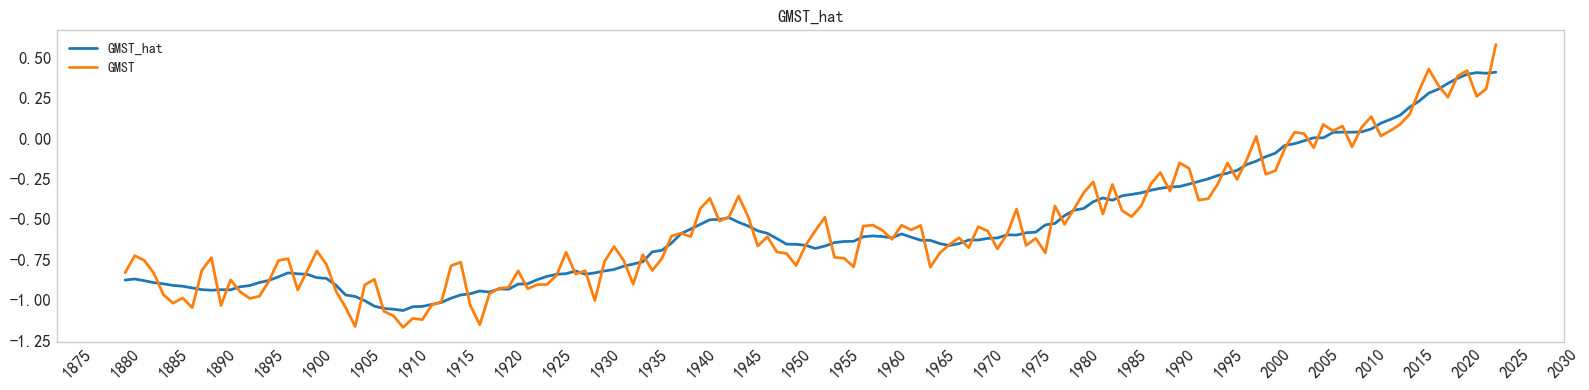

In [17]:
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False
fig,ax = plt.subplots(1,1,figsize=(16,4) )
ax.plot(date,GMST_hat,lw = 2.0,label = "GMST_hat")
ax.plot(date,GMST,lw = 2.0,label = "GMST")
plt.legend(loc = "best")
plt.grid()
ax.tick_params(axis='both', which='major', labelsize=12)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.tick_params(axis='x', rotation=45)
ax.set_title("GMST_hat")

plt.tight_layout()
plt.show()

## IMF剩下求和


In [186]:
IMF_sum = np.sum(eIMFs[:1],axis=0)+res
IMF_sum.shape
IMF_restruct = IMF_sum*std+ np.polyval(p, t - t0)

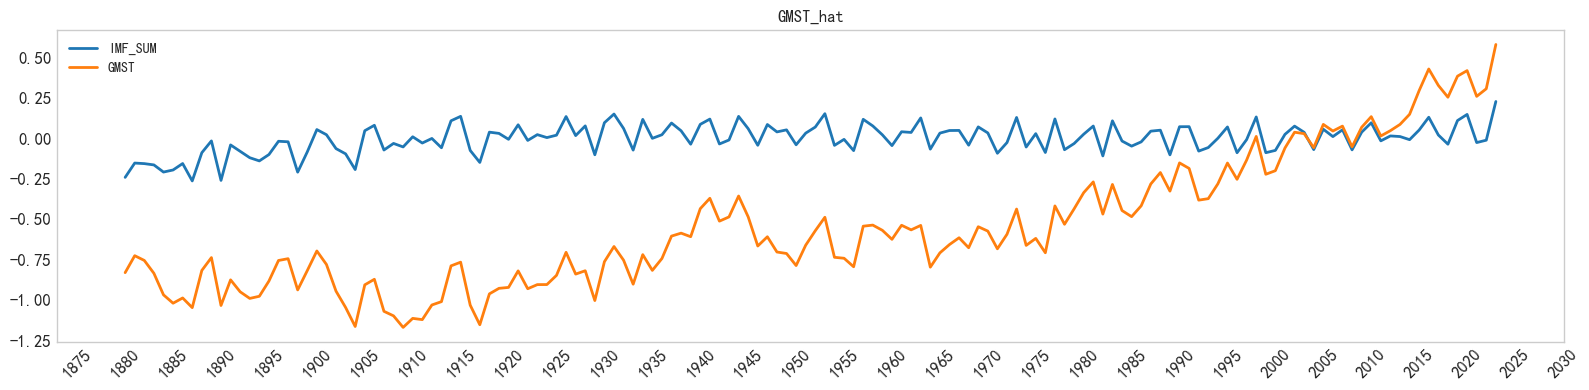

In [187]:
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False
fig,ax = plt.subplots(1,1,figsize=(16,4) )
ax.plot(date,IMF_restruct,lw = 2.0,label = "IMF_SUM")
ax.plot(date,GMST,lw = 2.0,label = "GMST")
plt.legend(loc = "best")
plt.grid()
ax.tick_params(axis='both', which='major', labelsize=12)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.tick_params(axis='x', rotation=45)
ax.set_title("GMST_hat")

plt.tight_layout()
plt.show()

## 做快速上升

In [19]:
import pandas as pd

In [22]:
GMST_EEMD = pd.DataFrame(GMST_hat)
GMST_EEMD.to_csv("GMST_EEMD.csv")